In [29]:
#scientific libraries and plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

#torch specific
import torch
import torchvision as torchv
import torch.optim as optim

#other libraries
import time
import sys
from pathlib import Path
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import atlas_mpl_style as ampl

#Using newest versions of all libraries

In [30]:
# import custom functions from src folder
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from machine_learning import *
from resnet import *
from resnet import ResNet18
from imcal import *
from imcal import CalorimeterDataset
from imcal import Hdf5Dataset
from imcal import RandomRoll
from imcal import plot_conf_matrix

In [41]:
#variables controlled by the user. Change these to fit your specific needs.
TRAIN_N_EVENTS = 9000 #Number of events to process for each class. If higher than the available number of events an exception will be raised.
TEST_N_EVENTS = 3000 #Number of events to process for each class. If higher than the available number of events an exception will be raised.
RES = 50 #resolution
"""
#Data specification
LABELS = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "BH_n4_M8", "BH_n4_M10", "BH_n4_M12"] #for plotting #"PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", 
TEST_LABELS = [f"{label}_test" for label in LABELS]
PLOT_LABELS = ["SPH_9TEV", "BH_n4_M8", "BH_n4_M10", "BH_n4_M12"]
CLASSES = len(LABELS) #The number of output nodes in the net, equal to the number of classes
FOLDERS = ["sph", "BH", "BH", "BH"]
"""

LABELS = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "BH_n4_M10"] #The labels in the hdf5 dataset
TEST_LABELS = [f"{label}_test" for label in LABELS]
PLOT_LABELS = ["SPH_9TeV", "BH_n4_M10"] #For plotting
CLASSES = len(LABELS) #The number of output nodes in the net, equal to the number of classes
FOLDERS = ["sph", "BH"]
N_EVENTS = [50000, 25000]
CUT=True

#Set data paths
if CUT:
    TRAIN_FILENAMES = [f"{label}_res{RES}_STmin7_Nmin5_{n}_events.h5" for label, n in zip(LABELS, N_EVENTS)]
    TEST_FILENAMES = [f"{label}_res{RES}_STmin7_Nmin5_3000_events.h5" for label in TEST_LABELS]
else:
    TRAIN_FILENAMES = [f"{label}_res{RES}_{n}_events.h5" for label, n in zip(LABELS, N_EVENTS)]
    TEST_FILENAMES = [f"{label}_res{RES}_3000_events.h5" for label in TEST_LABELS]
TRAIN_DATAPATHS = [f"/disk/atlas3/data_MC/2dhistograms/{FOLDERS[i]}/{RES}/{TRAIN_FILENAMES[i]}" for i in range(CLASSES)]
TEST_DATAPATHS = [f"/disk/atlas3/data_MC/2dhistograms/{FOLDERS[i]}/{RES}/{TEST_FILENAMES[i]}" for i in range(CLASSES)]

#Set a unique name for the model
labelstring = '_'.join([str(elem) for elem in PLOT_LABELS])
if CUT:
    MODEL_NAME = f"resnet_{str(int(time.time()))}_{labelstring}_CUT"
else: MODEL_NAME = f"resnet_{str(int(time.time()))}_{labelstring}"
print(MODEL_NAME)
SAVE_FOLDER = "/home/agrefsru/imcalML/results/models"
SAVE_PATH = f"{SAVE_FOLDER}/{MODEL_NAME}.pt"

#Setup GPU if available
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    torch.cuda.empty_cache()
    print("Running on the GPU")
else:
    DEVICE = torch.device("cpu")
    print("Running on the CPU")

#Data processing
#filters=["saturate", "normalise"]
filters=None
transforms = torch.nn.Sequential(
        torchv.transforms.RandomVerticalFlip(),
        RandomRoll(roll_axis=0)
    )
#transforms=None
ampl.use_atlas_style()   
#sn.set_theme(context="notebook", style="white", palette="Paired", font='sans-serif', font_scale=1.5, color_codes=True, rc=None)

resnet_1675347192_SPH_9TeV_BH_n4_M10_CUT
Running on the GPU


In [32]:
#load data in memory
"""
trainpaths = [Path(TRAIN_DATAPATH/file) for file in TRAIN_FILENAMES]
testpaths = [Path(TEST_DATAPATH/file) for file in TEST_FILENAMES]
train_data = load_datasets(trainpaths, DEVICE, TRAIN_N_EVENTS, filters, transforms)
test_data = load_datasets(testpaths, DEVICE, TEST_N_EVENTS, filters, transforms)"""


testpaths = [Path(path) for path in TEST_DATAPATHS]
#print(testpaths)

#Load lazily
test_data = Hdf5Dataset(testpaths, TEST_LABELS, DEVICE, 
                        shuffle=False, filters=filters, transform=None)

trainpaths = [Path(path) for path in TRAIN_DATAPATHS]
print(trainpaths)
#Load directly to speed up
train_data = load_datasets(trainpaths, DEVICE, TRAIN_N_EVENTS, filters, transforms)
#train_data = Hdf5Dataset(trainpaths, ["BH_n5_M8", "PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL"], DEVICE, 
                    #shuffle=True, transform=transforms, event_limit=TRAIN_N_EVENTS)

[PosixPath('/disk/atlas3/data_MC/2dhistograms/sph/50/PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_res50_STmin7_Nmin5_50000_events.h5'), PosixPath('/disk/atlas3/data_MC/2dhistograms/BH/50/BH_n4_M10_res50_STmin7_Nmin5_25000_events.h5')]
Loads data with transforms Sequential(
  (0): RandomVerticalFlip(p=0.5)
  (1): RandomRoll()
) and filters None
Loaded data with 9000 entries of shape (9000, 50, 50, 3).
Check max value: 17030.958984375.
Loaded data with 9000 entries of shape (9000, 50, 50, 3).
Check max value: 26107.572265625.
Data has shape torch.Size([50, 50, 3])
There are 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[['SPH_9TeV', 'SPH_9TeV'], ['BH_n4_M10', 'BH_n4_M10']]
[[0, 0], [1, 1]]
[[68, 62], [9010, 9077]]
Image shape:  (50, 50, 3)


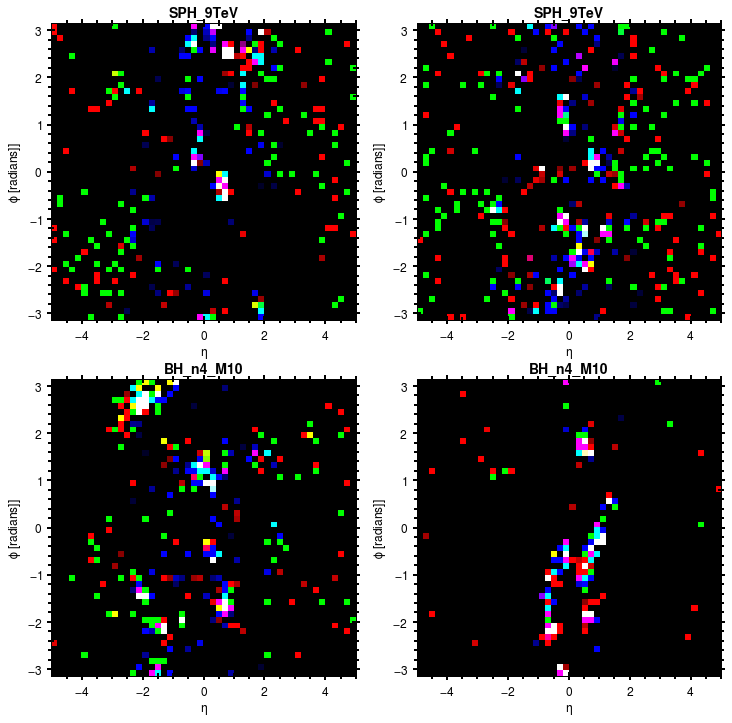

In [33]:
view_data(train_data, 2, CLASSES, PLOT_LABELS, RES, TRAIN_N_EVENTS)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Look at the highest histogram values values for a random image
[ 366.6803   461.3808   509.36453  562.2618   795.2287   831.47644
  961.3847   992.2381  1050.1532 ]
Looking at image 15659


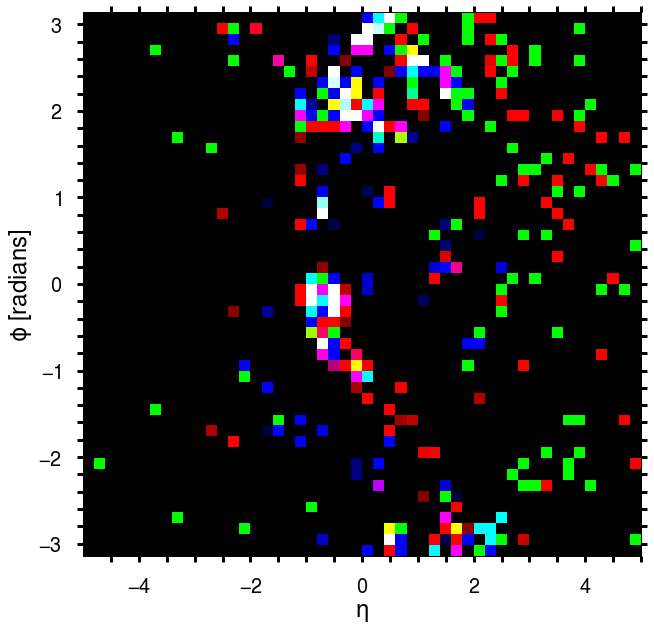

In [34]:
k = np.random.randint(0, len(train_data))
image = train_data[k][0].cpu()
print("Look at the highest histogram values values for a random image")
print(np.sort(image.flatten())[-10:-1])
print("Looking at image", k)

fig, ax = plt.subplots(ncols=1, figsize=(10, 10))
ax.imshow(image, extent=[-5, 5, -np.pi, np.pi], aspect='auto')
cal_image_plot_paper(ax)
ax.tick_params(which="both", direction="out", bottom=True, left=True, labelsize=20, pad=15, length=6, width=3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


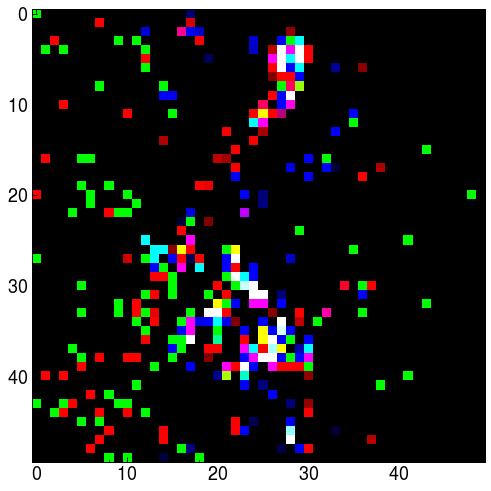

In [35]:
#Check augmentation

if transforms!=None:
    rolled_image = transforms(image)
    plt.imshow(rolled_image)

### Create net and train

In [36]:
#create NN and test that nothing major is wrong.
resnet = ResNet18(img_channels=3, num_classes=CLASSES)
resnet.to(DEVICE)

#testimage, testlabel = traindata.images[0], traindata.img_labels[0]
testimage, testlabel = train_data[0][0], train_data[0][1]
print(testimage.view(-1, 3, RES, RES).shape)
print(resnet(testimage.view(-1, 3, RES, RES).to(DEVICE)))

torch.Size([1, 3, 50, 50])
tensor([[-0.4816, -0.2760]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [37]:
#Set optimizer, learning rate scheduler and train the model
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
#scheduler = optim.lr_scheduler.CyclicLR(optimizer, 0.0001, 0.01, cycle_momentum=False)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=0.001,step_size_up=5,mode="exp_range",gamma=0.85, cycle_momentum=False)
training_results = train(resnet, train_data, test_data, 2**8, 30, RES, DEVICE, optimizer, scheduler)

100%|██████████| 30/30 [03:11<00:00,  6.40s/it]


In [38]:
k = np.random.randint(0, len(test_data))
testimage, testlabel = test_data[k][0], test_data[k][1]
print(testimage.view(-1, 3, RES, RES).shape)
print(resnet(testimage.view(-1, 3, RES, RES).to(DEVICE)), testlabel)

torch.Size([1, 3, 50, 50])
tensor([[-1.4428,  0.6144]], device='cuda:0', grad_fn=<AddmmBackward0>) tensor([0., 1.], device='cuda:0', dtype=torch.float64)


(0.0, 1.0)

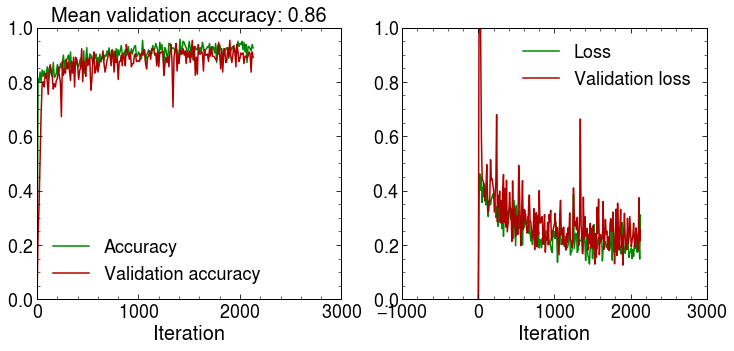

In [39]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
training_results.plot("Iteration", ["Accuracy", "Validation accuracy"], ax=axs[0], 
                    title="Mean validation accuracy: " + str(round(training_results["Validation accuracy"].mean(), 2)))
training_results.plot("Iteration", ["Loss", "Validation loss"], ax=axs[1])
axs[0].set_ylim(0, 1)
axs[0].set_xlim(0)
axs[1].set_ylim(0, 1)

In [42]:
truth, preds, losses, values = predict(resnet, test_data, CLASSES, 1, RES, DEVICE, return_loss=True, return_values=True)
confusion = pd.DataFrame(dict(zip(["Truth", "Predictions"], [truth, preds])))
accuracy = accuracy_score(truth, preds, normalize=True)

100%|██████████| 2499/2499 [00:18<00:00, 137.54it/s]


In [43]:
#Save model
torch.save(resnet.state_dict(), SAVE_PATH)

[0.921 0.079 0.108 0.892]


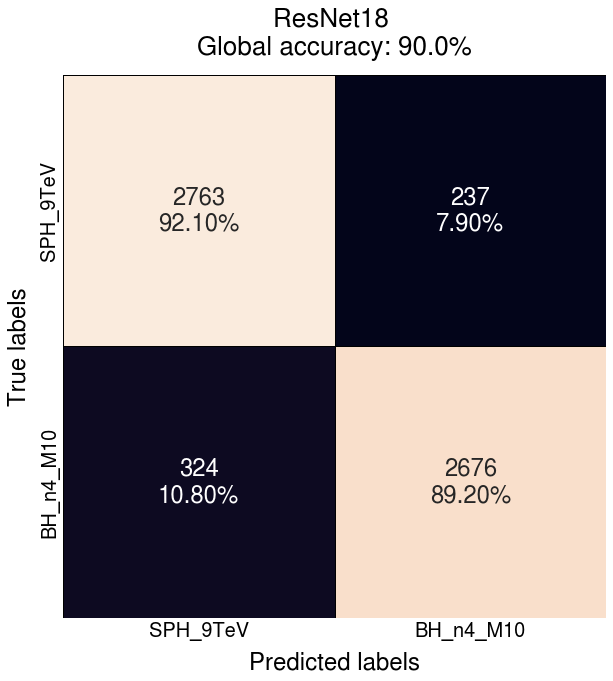

In [44]:
def plot_conf_matrix(confusion, accuracy, labels):
    """
    plot confusion matrix
    """
    fig, ax = plt.subplots(1,1, figsize=(10,10))

    #Generate the confusion matrix
    cf_matrix = confusion_matrix(confusion["Truth"], confusion["Predictions"], normalize="true")
    cf_matrix = np.round(cf_matrix, 3)
    print(cf_matrix.flatten())
    group_counts = ["{0:0.0f}".format(value*TEST_N_EVENTS) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()]
    annot = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
    annot = np.asarray(annot).reshape(len(labels),len(labels))
    sn.heatmap(
            cf_matrix, 
            ax=ax, 
            annot=annot, 
            cmap='rocket', 
            linewidths=1.0, 
            linecolor='black',
            cbar = False, 
            square=True, 
            fmt='', 
            cbar_kws={'format':'%.0f'},
            annot_kws={"size": 24}
        )

    #ax.set_title('Confusion matrix\n\n', size=24)
    ax.set_xlabel('Predicted labels', size=24, labelpad= 10)
    ax.set_ylabel('True labels', size=24, labelpad = 10)

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(labels, size=20)
    ax.yaxis.set_ticklabels(labels, size=20)
    ax.tick_params(which="both", left=False, bottom=False, top=False, right=False)
    ax.set_title(f"ResNet18 \nGlobal accuracy: {round(accuracy, 2)*100}%", size=26, pad=20)

    ## Display the visualization of the Confusion Matrix.
    plt.show()
plot_conf_matrix(confusion, accuracy, PLOT_LABELS)

In [45]:
confusion["Event_ID"] = np.arange(0, len(confusion))
confusion["Correct_Pred"] = [confusion["Predictions"][i] == confusion["Truth"][i] for i in range(len(confusion))]
confusion["Losses"] = losses
confusion["Class_1_value"] = values[:,0]
confusion["Class_2_value"] = values[:,1]
confusion["Difference"] = abs(confusion["Class_1_value"] - confusion["Class_2_value"])
arg_chosen_value = np.asarray(preds.tolist())
chosen_value = [values[i, int(arg)].tolist() for i, arg in enumerate(arg_chosen_value)]
confusion["Best choice"] = chosen_value
#wrong_id = confusion[confusion["Correct_Pred"]==False]["Event_ID"].tolist()

In [46]:
confusion

,Truth,Predictions,Event_ID,Correct_Pred,Losses,Class_1_value,Class_2_value,Difference,Best choice
0,0.0,0.0,0,True,0.251186,0.777878,0.222122,0.555755,0.777878
1,0.0,0.0,1,True,0.116581,0.889958,0.110042,0.779916,0.889958
2,0.0,0.0,2,True,0.199841,0.818861,0.181139,0.637722,0.818861
3,0.0,0.0,3,True,0.031520,0.968972,0.031028,0.937944,0.968972
4,0.0,0.0,4,True,0.002472,0.997531,0.002469,0.995063,0.997531
...,...,...,...,...,...,...,...,...,...
2494,1.0,1.0,2494,True,0.004528,0.004518,0.995482,0.990965,0.995482
2495,1.0,1.0,2495,True,0.000194,0.000194,0.999806,0.999612,0.999806
2496,1.0,1.0,2496,True,0.010990,0.010930,0.989070,0.978140,0.989070
2497,1.0,1.0,2497,True,0.005960,0.005942,0.994058,0.988115,0.994058


In [47]:
confusion.sort_values(by=["Losses"], ascending=False, inplace=True, ignore_index=True)
#confusion.sort_values(by=["Correct_Pred"], ascending=True, inplace=True, ignore_index=True)
#print(confusion[confusion["Truth"]>0])
print(confusion)

      Truth  Predictions  Event_ID  Correct_Pred        Losses  Class_1_value  \
0       0.0          1.0       304         False  6.217409e+00   1.994407e-03   
1       0.0          1.0       525         False  5.002125e+00   6.723645e-03   
2       1.0          0.0      2376         False  4.921184e+00   9.927095e-01   
3       1.0          0.0      1662         False  4.641828e+00   9.903599e-01   
4       1.0          0.0      1378         False  4.498970e+00   9.888796e-01   
...     ...          ...       ...           ...           ...            ...   
2494    1.0          1.0       719          True  1.430510e-06   1.431739e-06   
2495    1.0          1.0       684          True  1.430510e-06   1.461085e-06   
2496    1.0          1.0      1967          True  9.536739e-07   9.863297e-07   
2497    1.0          1.0       843          True  3.576278e-07   4.006692e-07   
2498    1.0          1.0      2390          True  3.576278e-07   3.767846e-07   

      Class_2_value  Differ

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Look at the highest histogram values values for a random image
[ 430.88077  492.1924   575.6481   578.91437  686.94836  749.5943
 1164.7821  1442.857   2103.9297 ]
Looking at image 304


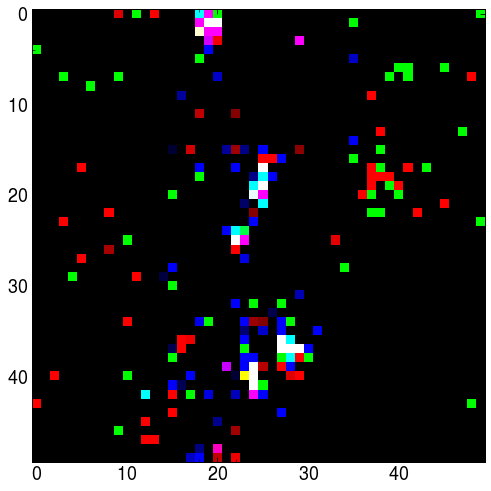

In [48]:
k = confusion["Event_ID"][0]
image = test_data[k][0].cpu()
print("Look at the highest histogram values values for a random image")
print(np.sort(image.flatten())[-10:-1])
print("Looking at image", k)

plt.imshow(image)

Text(0.5, 0, 'Softmax(y)')

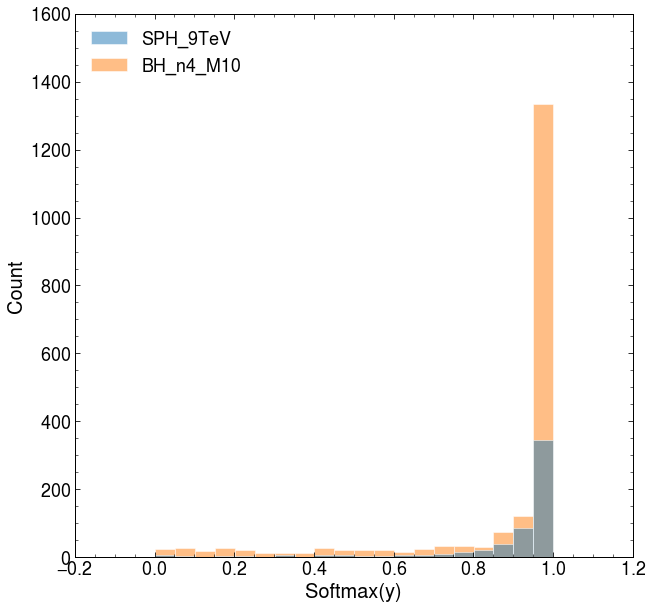

In [49]:
sph_softmax = confusion[confusion["Truth"]==0]["Class_1_value"]
bh_softmax = confusion[confusion["Truth"]==1]["Class_2_value"]
softmaxes = dict(zip(PLOT_LABELS, [sph_softmax, bh_softmax]))

fig, ax = plt.subplots(ncols=1, figsize=(10, 10))
sn.histplot(softmaxes, ax=ax, multiple="layer", stat="count", palette="tab10", bins=20)
sn.move_legend(ax, "upper left")
#ax.set_yscale("log")
ax.set_xlabel("Softmax(y)")